In [1]:
# General Imports
import numpy as np

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit_machine_learning.kernels import QuantumKernel

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.neural_networks import CircuitQNN

In [2]:
# Generate random inputs
inputs = np.random.uniform(low=0.0, high=np.pi, size=3)
print(inputs)

[0.10545144 1.80110498 1.88227534]


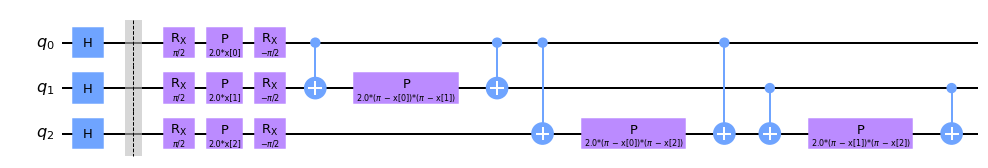

In [3]:
# Encode random vector into a circuit

%matplotlib inline

inputs = np.random.uniform(low=0.0, high=np.pi, size=3)


def encode_map(input_data, dim = 3):
    
    q_num = len(input_data)
    encode_map = PauliFeatureMap(feature_dimension=dim, reps=1, insert_barriers=True, paulis = ['Y','ZZ'])
    #encode_circuit = encode_map.bind_parameters(input_data)
    
    return encode_map


feature_map = encode_map(inputs, dim=3)

feature_map.decompose().draw(output='mpl')

In [5]:
# Construct teacher and student networks

from qiskit.circuit.library import RealAmplitudes


def teacher_circuit_builder(num_qubits):
    circuit = QuantumCircuit(num_qubits)

    circuit.h(0)
    circuit.cx(0, 1)
    circuit.h(0)
    circuit.h(1)
    circuit.cx(1, 2)
    circuit.h(1)
    #circuit.h(2)
    #circuit.cx(2, 3)
    #circuit.h(2)
    #circuit.h(3)
    #circuit.cx(3, 4)
    #circuit.h(3)
    
    return circuit


def student_network_builder(num_qubits):
    circuit = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cx', entanglement='linear', rotation_blocks=['ry'], insert_barriers=True).decompose()
    
    return circuit

teacher_circuit = teacher_circuit_builder(3)
print(teacher_circuit)

student_network = student_network_builder(3)
print(student_network)



     ┌───┐     ┌───┐          
q_0: ┤ H ├──■──┤ H ├──────────
     └───┘┌─┴─┐├───┤     ┌───┐
q_1: ─────┤ X ├┤ H ├──■──┤ H ├
          └───┘└───┘┌─┴─┐└───┘
q_2: ───────────────┤ X ├─────
                    └───┘     
     ┌──────────┐ ░            ░ ┌──────────┐ ░            ░ ┌──────────┐
q_0: ┤ Ry(θ[0]) ├─░───■────────░─┤ Ry(θ[3]) ├─░───■────────░─┤ Ry(θ[6]) ├
     ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤
q_1: ┤ Ry(θ[1]) ├─░─┤ X ├──■───░─┤ Ry(θ[4]) ├─░─┤ X ├──■───░─┤ Ry(θ[7]) ├
     ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤
q_2: ┤ Ry(θ[2]) ├─░──────┤ X ├─░─┤ Ry(θ[5]) ├─░──────┤ X ├─░─┤ Ry(θ[8]) ├
     └──────────┘ ░      └───┘ ░ └──────────┘ ░      └───┘ ░ └──────────┘


# Teacher Circuit from Amplitude Estimation 

In [6]:
from qiskit.opflow import NaturalGradient

from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit.algorithms import IterativeAmplitudeEstimation,AmplitudeEstimation, EstimationProblem
from qiskit_finance.applications.estimation import EuropeanCallPricing
from qiskit_finance.circuit.library import NormalDistribution, LogNormalDistribution

#number of qubits to represent the uncertainty
num_uncertainty_qubits = 1

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw()




┌──────┐┌────┐
q_0: ┤ P(X) ├┤0   ├
     └──────┘│    │
q_1: ────────┤1 F ├
             │    │
q_2: ────────┤2   ├
             └────┘

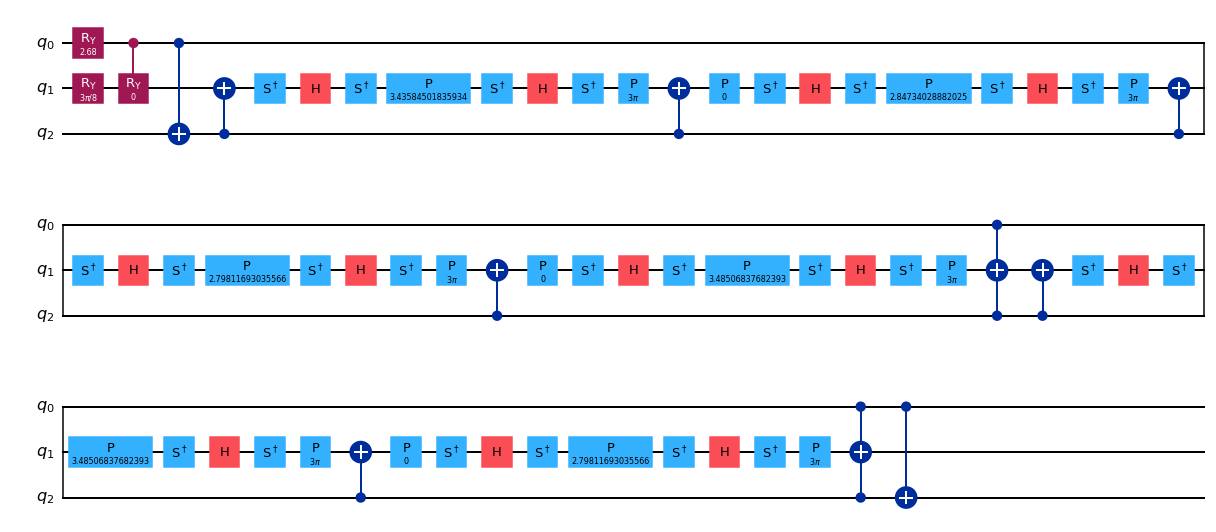

In [7]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[1],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

ae_circuit = ae.construct_circuit(problem)

ae_circuit.decompose().draw(
    "mpl", style="iqx"
)  # decompose 1 level: exposes the Phase estimation circuit!


from qiskit import transpile
basis_gates = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
transpile(ae_circuit, basis_gates=basis_gates, optimization_level=2).draw("mpl", style="iqx")



In [8]:
ae_teacher_circuit = transpile(ae_circuit, basis_gates=basis_gates, optimization_level=2)

#ae_teacher_circuit.draw()

teacher_circuit = ae_teacher_circuit

In [9]:
# Glue together feature map and network


tc_full = feature_map.compose(teacher_circuit)

sc_full = feature_map.compose(student_network)


print(sc_full.parameters)
print(teacher_circuit.parameters)

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8])])
ParameterView([])


In [10]:
# set up backed

from qiskit import Aer
from qiskit.utils import QuantumInstance

backend = Aer.get_backend('qasm_simulator')
q_instance = QuantumInstance(backend, shots = 100, seed_simulator = 2718, seed_transpiler = 2718)



In [11]:
#  QNN formulation


qnn_student = CircuitQNN(sc_full, feature_map.parameters, student_network.parameters, quantum_instance=q_instance)
qnn_teacher = CircuitQNN(tc_full, feature_map.parameters, teacher_circuit.parameters, quantum_instance=q_instance)




#input_data = [[0., 0.],[1., 1.] ]

#weights = [0. , 0., 0., 0.,0.,0.,0.,0.]

#print(qnn_student.forward(input_data, weights))
#print(qnn_teacher.forward(input_data, []))
#print(qnn_student.num_weights)


In [13]:
# Defining a PyTorch model and test it

from qiskit_machine_learning.connectors import TorchConnector
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss, KLDivLoss

initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn_student.num_weights) - 1)
print(initial_weights)
#initial_weights = [0. , 0., 0., 0.]
student_model = TorchConnector(qnn_student, initial_weights=initial_weights)
teacher_model = TorchConnector(qnn_teacher, initial_weights=[])


# test on a dummy input
input_data = [[0., 0., 0.],[1., 1., 1.]]

f_loss = MSELoss(reduction="sum")

ce_loss = CrossEntropyLoss() 

output = student_model(Tensor(input_data))  # Forward pass
target = teacher_model(Tensor(input_data))



print(output)

print(target)


print(f_loss(output, target))


[ 0.04174081 -0.05768226 -0.09151663  0.05043395 -0.00869563  0.02233297
 -0.03693855  0.09626855  0.02697694]
tensor([[0.1200, 0.0700, 0.1000, 0.1700, 0.1200, 0.1700, 0.0600, 0.1900],
        [0.0000, 0.0800, 0.0000, 0.8400, 0.0000, 0.0000, 0.0600, 0.0200]],
       grad_fn=<_TorchNNFunctionBackward>)
tensor([[0.0200, 0.1500, 0.1200, 0.1900, 0.0800, 0.0200, 0.1600, 0.2600],
        [0.0300, 0.0000, 0.0500, 0.0000, 0.1400, 0.0000, 0.7800, 0.0000]],
       grad_fn=<_TorchNNFunctionBackward>)
tensor(1.3100, grad_fn=<MseLossBackward0>)


In [14]:
import torch.optim as optim
# Define optimizer and loss
lr = 0.16
lr_min = 0.0005
optimizer = optim.Adam(student_model.parameters(), lr=lr)


mse_loss = MSELoss(reduction="mean")
ce_loss = CrossEntropyLoss() 
kl_div_loss = KLDivLoss()

# Start training
student_model.train()  # set model to training mode


# Note from (https://pytorch.org/docs/stable/optim.html):
# Some optimization algorithms such as LBFGS need to
# reevaluate the function multiple times, so you have to
# pass in a closure that allows them to recompute your model.
# The closure should clear the gradients, compute the loss,
# and return it.

epochs = 60
n_qbits = 3
loss_list = [] 

for epoch in range(epochs):
    total_loss = []
    
    print("Learning rate:", lr )
    
    
    for batch_idx in range(5):
        
        input_data = np.random.uniform(low=0.0, high=2. * np.pi, size=(8,n_qbits))
        
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        
        output = student_model(Tensor(input_data))  # Forward pass
        target = Tensor(qnn_teacher.forward(input_data, [])) # took a Qiskit QNN object defined above
        #teacher_model(Tensor(input_data))
        #print(target)
        mse_l = mse_loss(2**n_qbits * output, 2**n_qbits * target)
        ce_l = ce_loss(output,target) 
        kl_div_l = kl_div_loss(output,target) 
        
        
        
        loss = (mse_l + 0.0000*ce_l + 0.*kl_div_l) # Calculate loss
        
        #print(loss)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    
    if epoch % 10 == 0 and lr > lr_min :
        lr = lr / 2.
        
    print("MSE Loss {:.4f} CE_Loss: {:.4f} KL_Loss: {:.4f}".format(mse_l, ce_l, kl_div_l))
    
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))
    


Learning rate: 0.16


/Users/mykola/opt/anaconda3/envs/quantum_env3.8/lib/python3.8/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


MSE Loss 3.5438 CE_Loss: 2.1370 KL_Loss: -0.1751
Training [2%]	Loss: 4.5274
Learning rate: 0.08
MSE Loss 1.8056 CE_Loss: 2.0593 KL_Loss: -0.1926
Training [3%]	Loss: 2.3237
Learning rate: 0.08
MSE Loss 2.7434 CE_Loss: 2.0099 KL_Loss: -0.1804
Training [5%]	Loss: 3.1634
Learning rate: 0.08
MSE Loss 1.2190 CE_Loss: 2.0391 KL_Loss: -0.2135
Training [7%]	Loss: 2.3392
Learning rate: 0.08
MSE Loss 2.9652 CE_Loss: 2.0566 KL_Loss: -0.1659
Training [8%]	Loss: 2.5277
Learning rate: 0.08
MSE Loss 1.9856 CE_Loss: 1.9876 KL_Loss: -0.1710
Training [10%]	Loss: 2.2240
Learning rate: 0.08
MSE Loss 2.1376 CE_Loss: 2.0354 KL_Loss: -0.1941
Training [12%]	Loss: 1.9089
Learning rate: 0.08
MSE Loss 0.4216 CE_Loss: 1.9397 KL_Loss: -0.2110
Training [13%]	Loss: 0.8994
Learning rate: 0.08
MSE Loss 0.3088 CE_Loss: 1.8707 KL_Loss: -0.2055
Training [15%]	Loss: 0.3994
Learning rate: 0.08
MSE Loss 0.1932 CE_Loss: 1.8808 KL_Loss: -0.2044
Training [17%]	Loss: 0.3020
Learning rate: 0.08
MSE Loss 0.4362 CE_Loss: 1.8381 KL_

In [15]:
student_model.weight

Parameter containing:
tensor([ 2.8131, -0.6038, -1.5985,  0.1035, -3.0277, -0.0254, -0.0591, -1.3483,
         1.5391], requires_grad=True)

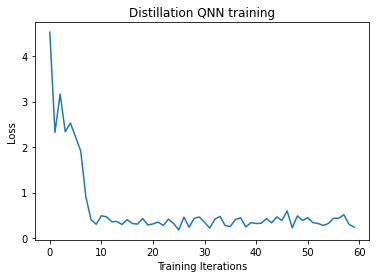

In [16]:
plt.plot(loss_list)
plt.title("Distillation QNN training")
plt.xlabel("Training Iterations")
plt.ylabel("Loss")
plt.show()

# Test histogram

In [18]:
qc2 = QuantumCircuit(3)
qc=qc2.compose(teacher_circuit)
qc.measure_all()
qc.draw()#.savefig('qae_circuit.pdf')

┌────────────┐                                      »
   q_0: ┤ Ry(2.6831) ├────■──────■──────────────────────────»
        └┬──────────┬┘┌───┴───┐  │  ┌───┐┌─────┐┌───┐┌─────┐»
   q_1: ─┤ Ry(3π/8) ├─┤ Ry(0) ├──┼──┤ X ├┤ Sdg ├┤ H ├┤ Sdg ├»
         └──────────┘ └───────┘┌─┴─┐└─┬─┘└─────┘└───┘└─────┘»
   q_2: ───────────────────────┤ X ├──■─────────────────────»
                               └───┘                        »
meas: 3/════════════════════════════════════════════════════»
                                                            »
«                                                                        »
«   q_0: ────────────────────────────────────────────────────────────────»
«        ┌─────────────────────┐┌─────┐┌───┐┌─────┐┌───────┐┌───┐┌──────┐»
«   q_1: ┤ P(3.43584501835934) ├┤ Sdg ├┤ H ├┤ Sdg ├┤ P(3π) ├┤ X ├┤ P(0) ├»
«        └─────────────────────┘└─────┘└───┘└─────┘└───────┘└─┬─┘└──────┘»
«   q_2: ─────────────────────────────────────────────────────■──────────»
«                                                                        »
«meas: 3/════════════════════════════════════════════════════════════════»
«                                                                        »
«                                                                              »
«   q_0: ──────────────────────────────────────────────────────────────────────»
«        ┌─────┐┌───┐┌─────┐┌─────────────────────┐┌─────┐┌───┐┌─────┐┌───────┐»
«   q_1: ┤ Sdg ├┤ H ├┤ Sdg ├┤ P(2.84734028882025) ├┤ Sdg ├┤ H ├┤ Sdg ├┤ P(3π) ├»
«        └─────┘└───┘└─────┘└─────────────────────┘└─────┘└───┘└─────┘└───────┘»
«   q_2: ──────────────────────────────────────────────────────────────────────»
«                                                                              »
«meas: 3/══════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                                          »
«   q_0: ──────────────────────────────────────────────────────────────────»
«        ┌───┐┌─────┐┌───┐┌─────┐┌─────────────────────┐┌─────┐┌───┐┌─────┐»
«   q_1: ┤ X ├┤ Sdg ├┤ H ├┤ Sdg ├┤ P(2.79811693035566) ├┤ Sdg ├┤ H ├┤ Sdg ├»
«        └─┬─┘└─────┘└───┘└─────┘└─────────────────────┘└─────┘└───┘└─────┘»
«   q_2: ──■───────────────────────────────────────────────────────────────»
«                                                                          »
«meas: 3/══════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                                        »
«   q_0: ────────────────────────────────────────────────────────────────»
«        ┌───────┐┌───┐┌──────┐┌─────┐┌───┐┌─────┐┌─────────────────────┐»
«   q_1: ┤ P(3π) ├┤ X ├┤ P(0) ├┤ Sdg ├┤ H ├┤ Sdg ├┤ P(3.48506837682393) ├»
«        └───────┘└─┬─┘└──────┘└─────┘└───┘└─────┘└─────────────────────┘»
«   q_2: ───────────■────────────────────────────────────────────────────»
«                                                                        »
«meas: 3/════════════════════════════════════════════════════════════════»
«                                                                        »
«                                                                 »
«   q_0: ──────────────────────────────■──────────────────────────»
«        ┌─────┐┌───┐┌─────┐┌───────┐┌─┴─┐┌───┐┌─────┐┌───┐┌─────┐»
«   q_1: ┤ Sdg ├┤ H ├┤ Sdg ├┤ P(3π) ├┤ X ├┤ X ├┤ Sdg ├┤ H ├┤ Sdg ├»
«        └─────┘└───┘└─────┘└───────┘└─┬─┘└─┬─┘└─────┘└───┘└─────┘»
«   q_2: ──────────────────────────────■────■─────────────────────»
«                                                                 »
«meas: 3/═════════════════════════════════════════════════════════»
«                                                                 »
«                                                                 

{'001': 328, '010': 23, '000': 40, '011': 633}


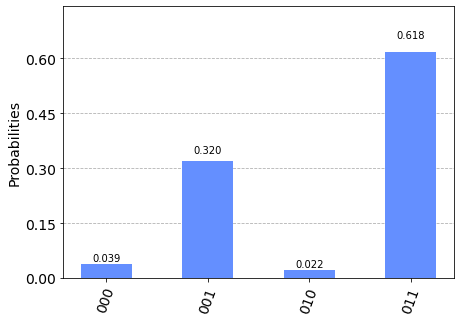

In [22]:
#choosing the qasm simulator backend

from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')

# running the job and getting results (counts)
job = execute(qc, backend, shots=1024) # shots = no. of times you want to run the experiment
result = job.result()
counts = result.get_counts(qc)

#printing and visualizing results (histogram data of experiment)
print(counts)
plot_histogram(counts)

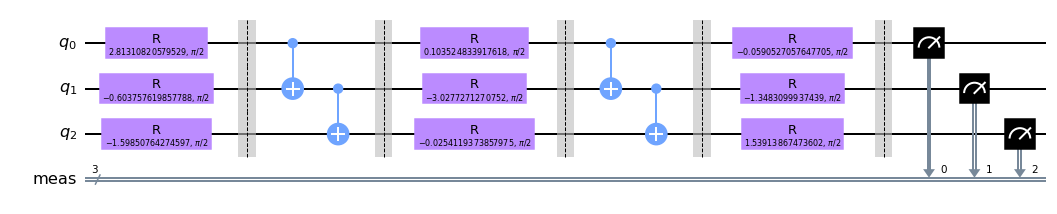

In [22]:
qc3 = QuantumCircuit(3)
qc=qc3.compose(student_network)
qc.assign_parameters(student_model.weight.detach().numpy(), inplace=True)

qc.measure_all()
qc.decompose().draw(output='mpl')

{'001': 604, '010': 7, '000': 48, '011': 365}


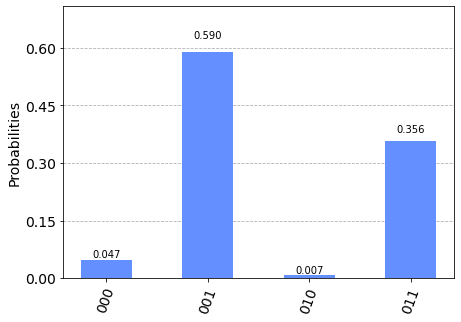

In [21]:
#choosing the qasm simulator backend

from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')

# running the job and getting results (counts)
job = execute(qc, backend, shots=1024) # shots = no. of times you want to run the experiment
result = job.result()
counts = result.get_counts(qc)

#printing and visualizing results (histogram data of experiment)
print(counts)
plot_histogram(counts)